In [16]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # здесь вы можете продолжить, например,cuda:1 cuda:2... и т. д. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [23]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.
class nnVibro():
    IMG_SIZE = 300
    DOWNS = "Train/downs"
    PEAKS = "Train/peaks"
    RISES = "Train/rises"
    TESTING = "Test"
    LABELS = {DOWNS: 0, PEAKS: 1, RISES: 2}
    training_data = []
    dcount = 0
    pcount = 0
    rcount = 0
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(3)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])
                        if label == self.DOWNS:
                            self.dcount += 1
                        elif label == self.PEAKS:
                            self.pcount += 1
                        elif label == self.RISES:
                            self.rcount += 1
                    except Exception as e:
                        pass
                        #print(label, f, str(e))
        np.random.shuffle(self.training_data)
        np.save("training_data2.npy", self.training_data)
        print('downs:',Netvibro.dcount)
        print('peaks:',Netvibro.pcount)
        print('rises:', Netvibro.rcount)
        
if REBUILD_DATA:
    Netvibro = nnVibro()
    Netvibro.make_training_data()
training_data = np.load("training_data2.npy", allow_pickle=True)
print(len(training_data))

Train/downs


100%|██████████| 300/300 [00:00<00:00, 617.60it/s]


Train/peaks


100%|██████████| 300/300 [00:00<00:00, 658.39it/s]


Train/rises


100%|██████████| 300/300 [00:00<00:00, 485.58it/s]


downs: 300
peaks: 300
rises: 300
900


In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)
        x = torch.randn(300,300).view(-1,1,300,300)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 3) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).
    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=147968, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [4]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size].to(device)
train_y = y[:-val_size].to(device)
test_X = X[-val_size:].to(device)
test_y = y[-val_size:].to(device)

print(len(train_X), len(test_X))

NameError: name 'net' is not defined

In [27]:

print(len(X))

900


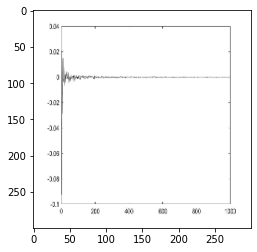

In [29]:
import matplotlib.pyplot as plt
plt.imshow(X[3], cmap="gray")